# PostProcessing object

In [1]:
# Core libraries
import numpy as np
import tensorflow as tf
import sys, os, datetime
sys.path.append('/home/andrea/AI/ispr_yolo/data')
sys.path.append('/home/andrea/AI/ispr_yolo/model')
from DataPreprocessing import generate_one_example, Preprocess
from utils import broadcast_iou, xywh_to_y1x1y2x2, xywh_to_x1x2y1y2
from lossfunction import decode_output, from_rel_to_abs
import matplotlib.pyplot as plt
import cv2 as cv

# Anchors
yolo_anchors = tf.constant([(19, 19), (43, 46), (94, 66), (77, 163), (163, 107), (253, 172), (237, 337), (388, 260), (514, 441)], tf.float32)

In [2]:
class PostProcessor():
    def __init__(self, iou_thresh, score_thresh, ground = False, max_detection=100, num_classes = 10):
        self.iou_thresh = iou_thresh
        self.score_thresh = score_thresh
        self.max_detection = max_detection
        self.num_classes = num_classes
        self.ground = ground
        self.class_names = ['bus', 'light', 'sign', 'person', 'bike',
                            'truck', 'motor', 'car', 'train', 'rider']

    def __call__(self, raw_yolo_outputs):
        boxes, objectness, class_probs = self.preprocess(raw_yolo_outputs)
        objectness, classes = self.split_multilabel(objectness, class_probs)
        
        final_boxes = self.non_max_sup(boxes, objectness, classes)

        return final_boxes
    
    def split_multilabel(self, objectness, classes):
        classes = tf.argmax(classes, axis = 1)
        full_classes = np.tile(classes, [10,1])
        full_objectness = np.tile(objectness, [10,1])
        for i in range(10):
            mask = np.equal(full_classes[i], i)
            full_classes[i] = full_classes[i]*mask
            full_objectness[i] = full_objectness[i]*mask
        return full_objectness, full_classes
            
    
    def non_max_sup(self, boxes, scores, class_probs):
        output = {}
        for i in range(10):
            selected_indices = tf.image.non_max_suppression(boxes, scores[i], 30, iou_threshold=self.iou_thresh, score_threshold=self.score_thresh)
            selected_boxes = tf.gather(boxes, selected_indices)
            selected_scores = tf.gather(scores[i], selected_indices)
            output[self.class_names[i]] = (selected_boxes, selected_scores)
        
        return output
    

        
    def preprocess(self, raw_yolo_outputs):
        boxes, objectness, class_probs = [], [], []
        
        for idx, out in enumerate(raw_yolo_outputs):
            if not self.ground: out = decode_output(out, yolo_anchors[3*idx:3*idx+3])
            y_box_abs, y_obj, y_class = from_rel_to_abs(out)
            y_box_abs = xywh_to_x1x2y1y2(y_box_abs)
            
            boxes.append(tf.reshape(y_box_abs, (-1, 4)))
            objectness.append(tf.reshape(y_obj, (-1)))
            class_probs.append(tf.reshape(y_class, (-1,10)))
            
        boxes = tf.concat(boxes, axis=0)
        objectness = tf.concat(objectness, axis=0)
        class_probs = tf.concat(class_probs, axis=0)
        return boxes, objectness, class_probs

In [7]:
prep = Preprocess(validation = True)
post = PostProcessor(iou_thresh=0.5, score_thresh=0.5, ground=True)
post_model = PostProcessor(iou_thresh=0.5, score_thresh=0.5, ground=False)
image_path = '/home/andrea/AI/ispr_yolo/data/dataset_bdd/images/100k/val/ba47af6d-548205ea.jpg'
weights_path = '/home/andrea/AI/ispr_yolo/NOTEBOOKS/training/softmax_augmented/fit/1028-190344ep008-loss109.459-val_loss124.646.h5'

In [8]:
def draw_boxes(image, boxes):
    color={
        'bus' : (1, 1, 0.4),
        'light' : (1, 0.2, 0.2),
        'sign' : (0.8, 0.8, 0.8),
        'person' : (0, 1, 0.5),
        'bike' : (0.8, 1, 0.6),
        'truck': (1, 0.6, 0.8),
        'motor' : (0.8, 0.8, 1),
        'car' : (0.2, 0.2, 1),
        'train' : (0.2, 1, 0),
        'rider' : (0.4, 0.4, 0.4)
    }
    image = np.float32(image)
    for classes, box_n_score in boxes.items():
        boxes, scores = box_n_score
        if boxes.shape[0] > 0:
            for box, score in zip(boxes,scores):
                pt1 = tuple(np.int32(box[0:2]*1280))
                pt2 = tuple(np.int32(box[2:4]*1280))
                image = cv.rectangle(image, pt1, pt2, color[classes], thickness=2)
                area = (pt1[0]-pt2[0])*(pt1[1]-pt2[1])
                if area > 1600:
                    pt1 = (pt1[0], pt1[1]-3)
                    text = classes + ': ' + str(round(float(score), 2))
                    image = cv.putText(image, text, pt1 , cv.FONT_HERSHEY_SIMPLEX, 0.7, (1,1,1), 2)
        else:
            pass
    return image

def show_me(model, path):
    img, label_ground = prep(image_path)
    
    img = tf.expand_dims(img, 0)
    label = yolo.predict(img)
    label = [tf.squeeze(x, axis = 0) for x in label]
    
    ground_output = post(label_ground)
    model_output = post_model(label)
    img = tf.squeeze(img, 0)
    return img, model_output, ground_output

def create_model(weights):
    yolo = YOLOv3(size = 1280, training = True)
    yolo.load_weights(weights)
    return yolo

from yolo import YOLOv3

In [9]:
yolo = create_model(weights_path)

In [17]:
import time
toc = 0
for i in range(100):
    img, label_ground = prep(image_path)
    tic = time.time()
    img = tf.expand_dims(img, 0)
    label = yolo.predict(img)
    toc += time.time()-tic
#     img = draw_boxes(img, boxes)
    
print(toc/100)

0.1513893723487854


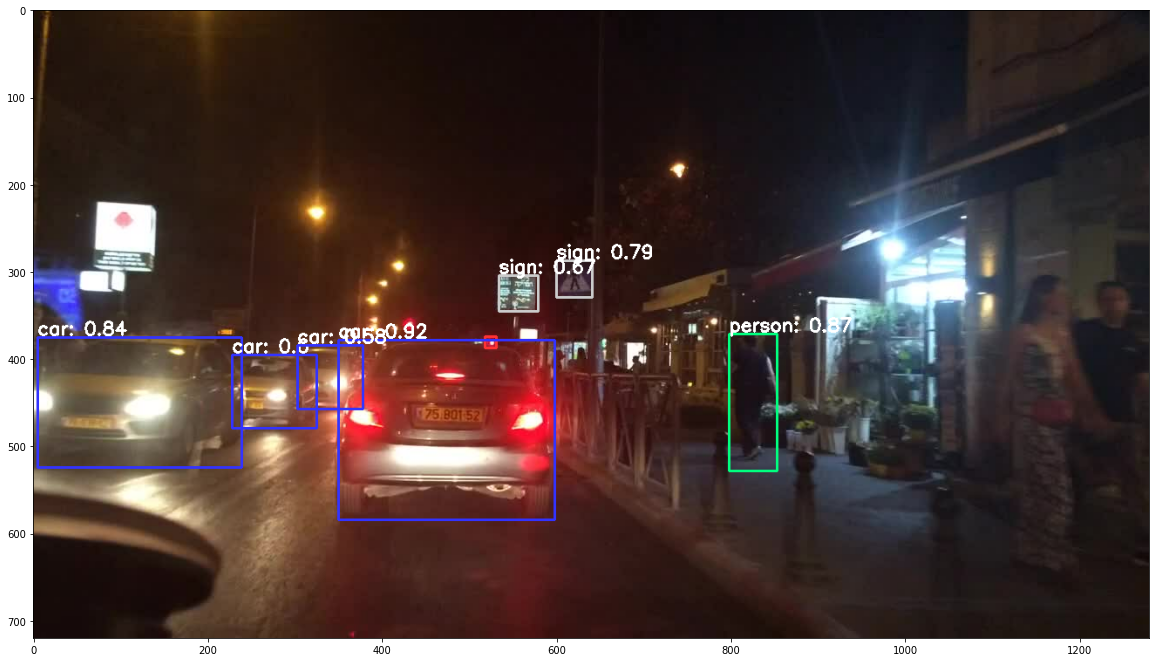

In [19]:
img, boxes, boxes_ground = show_me(yolo, image_path)
img = draw_boxes(img, boxes)



plt.figure(figsize = (20,20))
_ = plt.imshow(img[280:1000])

   Original BB: loaded from raw file
[440 318 60 54 1 0 0 1 0 0 0 0 0 0 0]

   Processed BB: inside the target label
array([  0.26748934,   0.6349199 ,  -6.937399  ,  -6.95952   ,
        -1.6008013 , -27.101456  , -20.189249  ,  20.762182  ,
       -28.770514  , -27.110828  , -27.071112  , -27.108854  ,
       -21.330137  , -27.305878  , -27.323767  ], dtype=float32)

   Postprocessed, step 1
Size of the postprocessed boxes tensor:  (100800, 4)
Elements im interested in:

[0.444745302 0.32641843 0.488424718 0.368162483]
selected boxes
[[[0.539644122 0.306206495 0.568389297 0.338852376]
  [0.505652368 0.449532956 0.515206635 0.457379252]
  [0.54420495 0.355686039 0.562395573 0.376550227]
  ...
  [0.524401844 0.304079115 0.533421218 0.31474638]
  [0.51177305 0.410933644 0.520425141 0.422304362]
  [0.523382962 0.512150526 0.533550203 0.521366954]]]


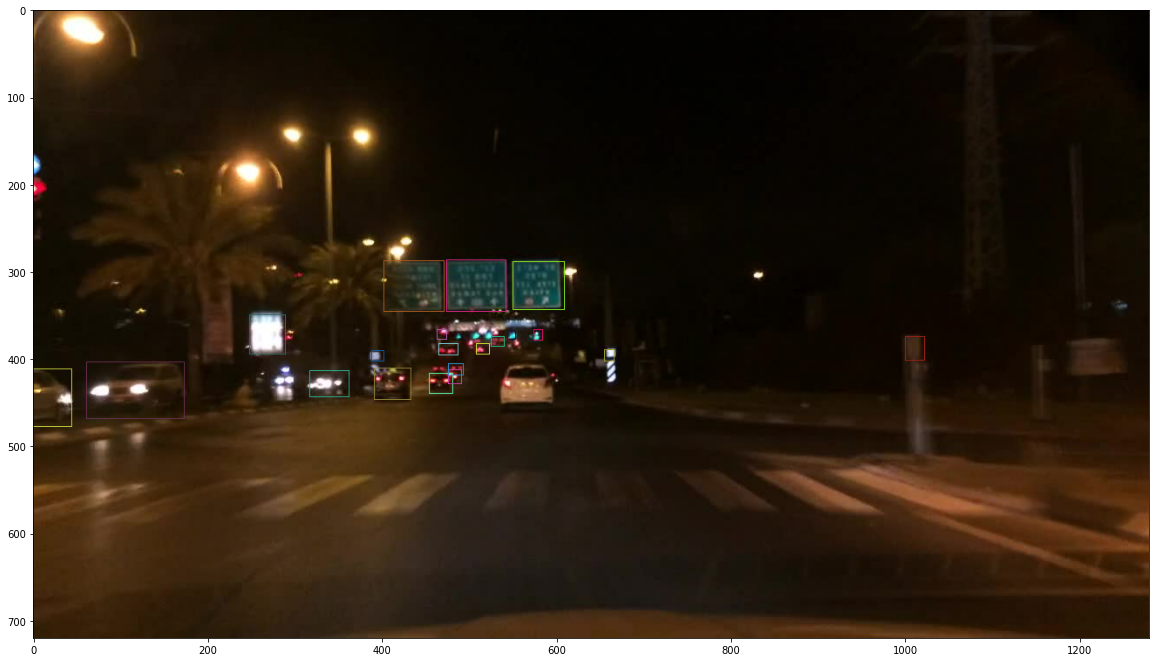

In [27]:
image_path = '/home/andrea/AI/ispr_yolo/data/dataset_bdd/images/100k/train/5823b731-7716da84.jpg'
prep = Preprocess()
img = prep.load_img(image_path)
label = prep.load_label(image_path)

# img1, label1 = generate_one_example()

# for i in label1:
#     tf.print(tf.shape(i))  

weights_path = '/home/andrea/AI/ispr_yolo/NOTEBOOKS/training/logs/fit/1013-001134ep024-loss88.743-val_loss105.085.h5'
image_path = '/home/andrea/AI/ispr_yolo/data/dataset_bdd/images/100k/val/be651ed5-2feb0be6.jpg'
prep = Preprocess(validation = True)
post = PostProcessor(iou_thresh=0.5, score_thresh=0.5)

sys.path.append('/home/andrea/AI/ispr_yolo/data')
sys.path.append('/home/andrea/AI/ispr_yolo/model')
from yolo import YOLOv3
yolo = YOLOv3(size = 1280, training = True)
yolo.load_weights(weights_path)

img = prep.load_img(image_path)


label = prep.load_label(image_path)
print('   Original BB: loaded from raw file')
tf.print(label[0, :], summarize = -1)
img, label = prep(image_path) 
img = tf.expand_dims(img, 0)
label = yolo.predict(img)

print('\n   Processed BB: inside the target label')
tf.print(label[0][0,74,55,1], summarize = -1)

label = [tf.squeeze(x, axis = 0) for x in label]
boxes, _, _ = post.preprocess(label)
print('\n   Postprocessed, step 1')
print('Size of the postprocessed boxes tensor: ', boxes.shape)
print('Elements im interested in:\n')
tf.print(boxes[35686])

    
boxes, classes = post(label)


boxes = tf.expand_dims(boxes, 0)
print('selected boxes')
tf.print(boxes)
# print('\n Postprocessed, step 2')
# tf.print(boxes[0, 2, :])


# boxes = tf.constant([291+280, 410, 344+280, 470], dtype = tf.float32) / 1280
# boxes = tf.expand_dims(boxes, 0)
# boxes = tf.expand_dims(boxes, 0)
import random as rn
colors = []
for i in range(100):
    colors.append([rn.random(), rn.random(), rn.random()])
colors = np.array(colors)
img = tf.image.draw_bounding_boxes(img, boxes, colors)
img = tf.squeeze(img)


plt.figure(figsize = (20,20))
_ = plt.imshow(img[280:1000, ...])




In [5]:
image_path = '/home/andrea/AI/ispr_yolo/data/dataset_bdd/images/100k/train/5823b731-7716da84.jpg'
prep = Preprocess()
img = prep.load_img(image_path)
label = prep.load_label(image_path)

